# Neural Network with triplet loss

In [ ]:
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def pairwise_distance(feature, squared=False):
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

In [ ]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]
 
    labels = tf.cast(labels, dtype='int32')
    embeddings = y_pred[:, 1:]

    pdist_matrix = pairwise_distance(embeddings, squared=True)
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    adjacency_not = math_ops.logical_not(adjacency)

    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    return semi_hard_triplet_loss_distance

### Dataset

In [ ]:
data = fetch_olivetti_faces()

images_dataset = data['images']
labels_dataset = data['target']

X = pd.DataFrame(images_dataset.reshape(400, 64*64))
y = pd.Series(labels_dataset)

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.3)

x_train = x_train.values.reshape(x_train.shape[0], 64, 64, 1)
x_test = x_test.values.reshape(x_test.shape[0], 64, 64, 1)

y_train = y_train.values
y_test = y_test.values

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  stratify=y_train, 
                                                  random_state=0,
                                                  test_size=0.2)

input_image_shape = (64, 64, 1)

### Model creation

In [ ]:
def create_base_network(image_input_shape, embedding_size):

    input = layers.Input((64, 64, 1))
    x = tf.keras.layers.BatchNormalization()(input)
    x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Conv2D(8, (5, 5), activation="tanh")(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Flatten()(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dense(embedding_size, activation="tanh")(x)
    base_network = keras.Model(input, x)

    return base_network

In [ ]:
batch_size = 256
epochs = 150
train_flag = True
embedding_size = 40
no_of_components = 2
step = 1

In [ ]:
base_network = create_base_network(input_image_shape, embedding_size)

input_images = layers.Input(shape=input_image_shape, name='input_image')
input_labels = layers.Input(shape=(1,), name='input_label')
embeddings = base_network([input_images])
labels_plus_embeddings = layers.concatenate([input_labels, embeddings])

model = Model(inputs=[input_images, input_labels],
              outputs=labels_plus_embeddings)

model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss=triplet_loss_adapted_from_tf,
              optimizer=opt)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 40)           63252       ['input_image[0][0]']            
                                                                                                  
 concatenate (Concatenate)      (None, 41)           0           ['input_label[0][0]',            
                                                                  'model[0][0]']            

### Train model

In [ ]:
dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

x_train = np.reshape(x_train, (len(x_train), x_train.shape[1], x_train.shape[1], 1))
x_val = np.reshape(x_val, (len(x_val), x_train.shape[1], x_train.shape[1], 1))

H = model.fit(
    x=[x_train,y_train],
    y=dummy_gt_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, y_val], dummy_gt_val))



Epoch 1/150
Instructions for updating:
Use `tf.cast` instead.
1/1 [==============================] - 4s 4s/step - loss: 0.8430 - val_loss: 0.9619
Epoch 2/150
1/1 [==============================] - 0s 88ms/step - loss: 0.8028 - val_loss: 0.9657
Epoch 3/150
1/1 [==============================] - 0s 99ms/step - loss: 0.7719 - val_loss: 0.9672
Epoch 4/150
1/1 [==============================] - 0s 86ms/step - loss: 0.7424 - val_loss: 0.9616
Epoch 5/150
1/1 [==============================] - 0s 86ms/step - loss: 0.7148 - val_loss: 0.9526
Epoch 6/150
1/1 [==============================] - 0s 88ms/step - loss: 0.7094 - val_loss: 0.9487
Epoch 7/150
1/1 [==============================] - 0s 92ms/step - loss: 0.7007 - val_loss: 0.9327
Epoch 8/150
1/1 [==============================] - 0s 87ms/step - loss: 0.6748 - val_loss: 0.9304
Epoch 9/150
1/1 [==============================] - 0s 90ms/step - loss: 0.6619 - val_loss: 0.9201
Epoch 10/150
1/1 [==============================] - 0s 85ms/step - los

### Results of model

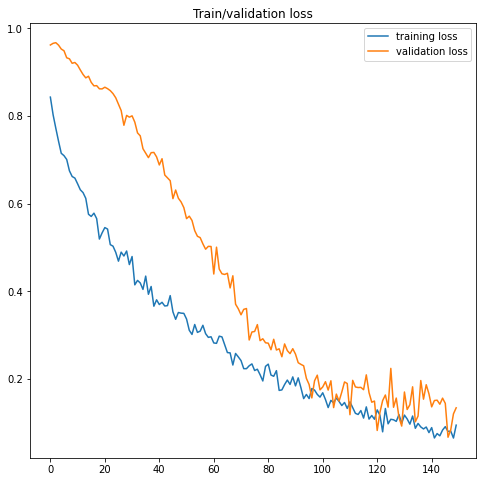

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(H.history['loss'], label='training loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

In [ ]:
testing_embeddings = create_base_network(input_image_shape,
                                          embedding_size=embedding_size)
x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 64, 64, 1)))
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

### PCA Decomposition

In [ ]:
x_embeddings = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 64, 64, 1)))
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_test))

pca = PCA(n_components=no_of_components)
decomposed_embeddings = pca.fit_transform(x_embeddings)
decomposed_gray = pca.fit_transform(x_embeddings_before_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


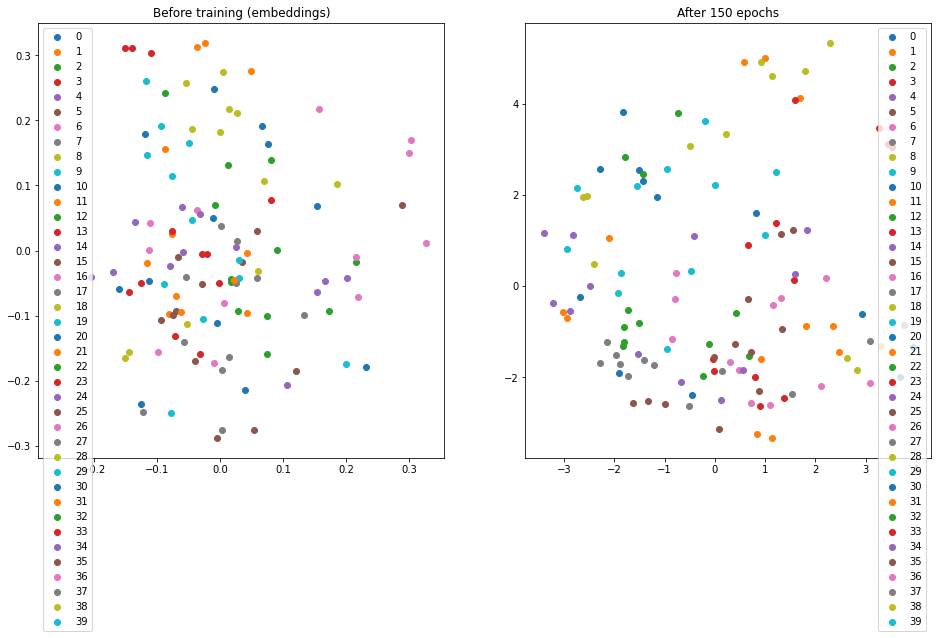

In [ ]:
fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
  decomposed_embeddings_class = decomposed_embeddings[y_test == label]
  decomposed_gray_class = decomposed_gray[y_test == label]

  plt.subplot(1,2,1)
  plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
  plt.title('Before training (embeddings)')
  plt.legend()

  plt.subplot(1,2,2)
  plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
  plt.title('After %d epochs' % epochs)
  plt.legend();

### Testing model

In [ ]:
clf = SVC()
cv_scores = cross_validate(clf, x_embeddings, y_test, return_train_score=True, cv=3)

print('Train scores: {}'.format(cv_scores['train_score']))
print('Test scores:  {}'.format(cv_scores['test_score']))

Train scores: [1.   0.95 0.95]
Test scores:  [0.75  0.85  0.875]


In [ ]:
clf = KNeighborsClassifier(metric='euclidean', n_neighbors=3)
cv_scores = cross_validate(clf, x_embeddings, y_test, return_train_score=True, cv=3)

print('Train scores: {}'.format(cv_scores['train_score']))
print('Test scores:  {}'.format(cv_scores['test_score']))

Train scores: [0.85   0.8375 0.775 ]
Test scores:  [0.75  0.725 0.725]
